In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from matplotlib import animation

# Example 1: The Pendulum

The differential equation for the pendulum of length $l$ hanging from some ceiling is 

$$\theta'' = -\frac{g}{l} \sin(\theta)$$

Solve this ODE subject to $\theta(0) = \pi/4$ and $\theta'(0) = 0$. Compare the solution to the solution of the approximate equation $\theta'' = -\frac{g}{l} \theta$

**Answer**: Since this is a second order ODE, we need to first convert it to a system of first order ODEs. Defining $\omega = \theta'$ we get two differential equations

* $\theta' = \omega$
* $\omega' = -(g/l) \sin(\theta)$

Letting $\vec{S} = [\theta, \omega]$, we proceed to write a function for $d\vec{S}/dt$

In [2]:
def dSdt(t, S, g, l):
    theta, omega = S
    return [omega,
            -(g/l)*np.sin(theta)]

Then we can define the initial conditions and plug into a solver:

In [11]:
S0 = [np.pi/40, 0]
g = 9.81 #m/s^2
l = 0.1 #m
t_span = (0,1)
t_eval = np.linspace(t_span[0], t_span[1], 100)
solution = solve_ivp(dSdt, t_span, S0, t_eval=t_eval, args=(g,l))

In [12]:
solution.y.shape

(2, 100)

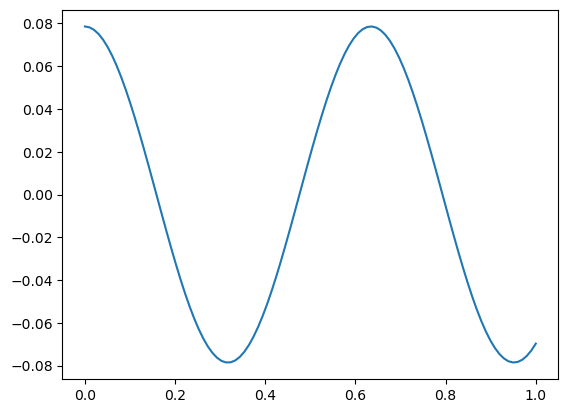

In [13]:
plt.plot(solution.t, solution.y[0])

We can compare this to the approximate solution given by solving $\theta'' = -\frac{g}{l} \theta$

* Note: this differential equation can be solved analytically, but we solve it numerically for practice

In [14]:
def dSdt_approx(t, S, g, l):
    theta, omega = S
    return [omega,
            -(g/l)*theta]
S0 = [np.pi/40, 0]
g = 9.81 #m/s^2
l = 0.1 #m
t_span = (0,1)
t_eval = np.linspace(t_span[0], t_span[1], 100)
solution_approx = solve_ivp(dSdt_approx, t_span, S0, t_eval=t_eval, args=(g,l))

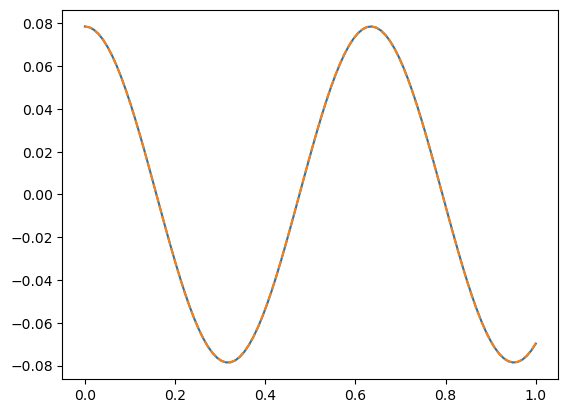

In [16]:
plt.plot(solution.t, solution.y[0])
plt.plot(solution.t, solution_approx.y[0], '--')

The exact solution differs from the approximate one, because we're not only at small angles (we start at $\theta=\pi/4$!)

# Example 2: 

The differential equations for projectile motion with friction are

$$\ddot{x} = -\frac{b}{m} (\sqrt{\dot{x}^2 + \dot{y}^2}) \dot{x}$$
$$\ddot{y} = -g -\frac{b}{m} (\sqrt{\dot{x}^2 + \dot{y}^2}) \dot{y}$$

For a projectile of mass $m=10$ kg launched from $[{x}(0), {y}(0)] = [0, 0]$  with initial speed $[\dot{x}(0), \dot{y}(0)] = [20\text{m/s}, 20\text{m/s}]$, plot the horizontal distance travelled before touching the ground as a function of the air friction parameter $b$

**Answer**: In order to get the horizontal distance travelled, we need to solve the system of ODEs, then find the time when $y=0$ (aka touches the ground). First we convert into four first order ODEs

* $\dot{x} = v_x$
* $\dot{y} = v_y$
* $\dot{v_x} = -\frac{b}{m} (\sqrt{v_x^2 + v_y^2}) v_x$
* $\dot{v_y} = -g -\frac{b}{m} (\sqrt{v_x^2 + v_y^2}) v_y$

Then letting $\vec{S} = [x,y,v_x,v_y]$ we define $d\vec{S}/dt$

In [17]:
def dSdt(t,S, b, m, g):
    x, y, vx, vy = S
    return [
        vx,
        vy,
        -b/m * np.sqrt(vx**2 + vy**2)*vx,
        -g - b/m * np.sqrt(vx**2 + vy**2)*vy
    ]

We can solve this for specific parameters

In [27]:
b = 5
g = 9.81
m = 10
S0 = [0, 0, 20, 20]
t_span = (0,5)
t_eval = np.linspace(t_span[0], t_span[1], 100)
solution = solve_ivp(dSdt, t_span, S0, t_eval=t_eval, args=[b, m, g])


(-2.0, 3.217824182041314)

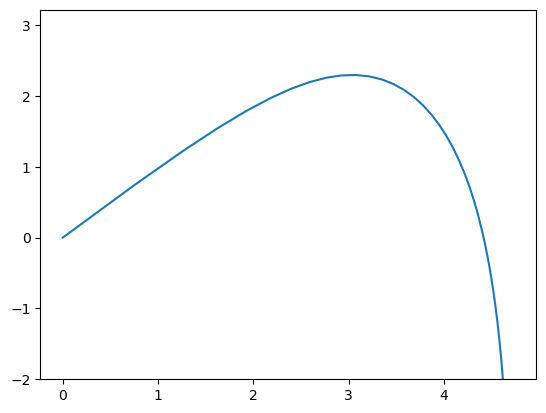

In [28]:
plt.plot(solution.y[0], solution.y[1])
plt.ylim(bottom=-2)

How do we get the $x$ position when it crosses the ground? For this we need the second time when $y=0$ (the first time is when it starts at the origin).

* For this we can use the interpolate function to get $x(y=0)$ using `np.interp(0,y,x)`

In [31]:
np.interp(0, solution.y[1][1:], solution.y[0][1:])

4.732611173872673

Now we can write a function to get this horizontal distance as a function of friction parameters

In [32]:
def get_horizonal_distance(b, m=10, g=9.81):
    solution = solve_ivp(dSdt, t_span, S0, t_eval=t_eval, args=[b, m, g])
    horizontal_distance = np.interp(0, solution.y[1][1:], solution.y[0][1:])
    return horizontal_distance

Get distances

In [33]:
bs = np.arange(0, 4, 0.1)
horizontal_distances = [get_horizonal_distance(b) for b in bs]

Text(0, 0.5, 'Horizontal Distance [m]')

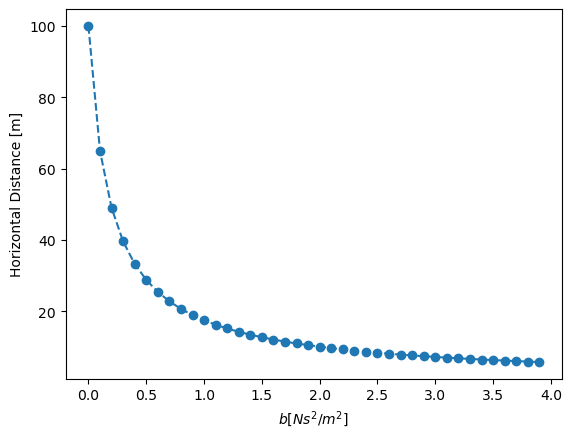

In [34]:
plt.plot(bs, horizontal_distances, 'o--')
plt.xlabel('$b [Ns^2/m^2]$')
plt.ylabel('Horizontal Distance [m]')

**Bonus**: Assuming that the curve above follows the relationship $d = f(b;c_1,c_2,c_3,c_4) = c_1e^{-c_2 \sqrt{b}} + c_3e^{-c_4\sqrt{b}}$ where $d$ is the horizontal distance traveled, use the `curve_fit` function to get the parameters $c_1$ and $c_2$

In [35]:
def fit_fun(b, c1, c2, c3, c4):
    return c1*np.exp(-c2*np.sqrt(b)) + c3*np.exp(-c4*np.sqrt(b))

Get best fit parameters and fit curve

In [36]:
popt, pcov = curve_fit(fit_fun, xdata=bs, ydata=horizontal_distances, p0=[100, 1, 100, 1])
bs_fit = np.linspace(min(bs), max(bs), 100)
horizontal_distances_fit = fit_fun(bs_fit, *popt)

Plot results next to the obtained data

Text(0, 0.5, 'Horizontal Distance [m]')

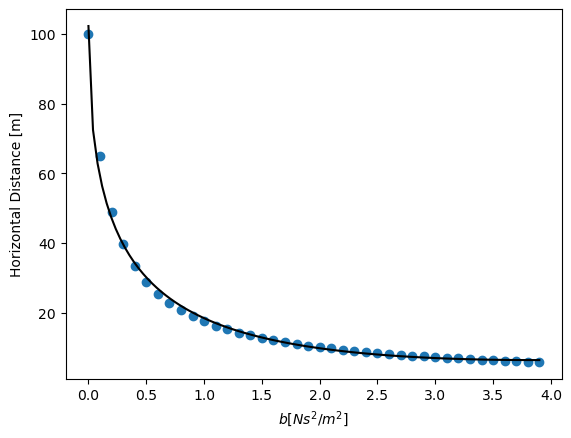

In [37]:
plt.plot(bs_fit, horizontal_distances_fit, color='k')
plt.scatter(bs, horizontal_distances)
plt.xlabel('$b [Ns^2/m^2]$')
plt.ylabel('Horizontal Distance [m]')

Notice that it may not be a perfect fit, but it appears to approximate mid values of $b$ fairly well.

# Example 3

(For extended coverage, see https://www.youtube.com/watch?v=otRtUiCcCh4&t=444s)

The six differential equations that describe 3 orbitting astronomical bodies

$$\ddot{x_1} = m_2\frac{(x_2-x_1)}{\sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}} + m_3 \frac{(x_3-x_1)}{\sqrt{(x_3-x_1)^2 + (y_3-y_1)^2}} $$
$$\ddot{y_1} = m_2\frac{(y_2-x_1)}{\sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}} + m_3 \frac{(y_3-x_1)}{\sqrt{(x_3-x_1)^2 + (y_3-y_1)^2}} $$
$$\ddot{x_2} = m_1\frac{(x_1-x_2)}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}} + m_3 \frac{(x_3-x_2)}{\sqrt{(x_3-x_2)^2 + (y_3-y_2)^2}} $$
$$\ddot{y_2} = m_1\frac{(y_1-y_2)}{\sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}} + m_3 \frac{(y_3-y_2)}{\sqrt{(x_3-x_2)^2 + (y_3-y_2)^2}} $$
$$\ddot{x_3} = m_1\frac{(x_1-x_3)}{\sqrt{(x_1-x_3)^2 + (y_1-y_3)^2}} + m_2 \frac{(x_2-x_3)}{\sqrt{(x_2-x_3)^2 + (y_2-y_3)^2}} $$
$$\ddot{y_3} = m_1\frac{(y_1-y_3)}{\sqrt{(x_1-x_3)^2 + (y_1-y_3)^2}} + m_2 \frac{(y_2-y_3)}{\sqrt{(x_2-x_3)^2 + (y_2-y_3)^2}} $$

where $(x_i, y_i)$ is the position of the ith body. Solve them for the parameters $m_1=m_2=1$ and $m_3=4$ and the initial conditions

Velocities:
* $x_1(0)' = 0.9911981217$
* $y_1(0)' = 0.7119472124$
* $x_2(0)' = 0.39295$
* $y_2(0)' = 0.09758$
* $x_3(0)' = -2 x_1(0)' / m_3$
* $y_3(0)' = -2 y_1(0)' / m_3$

Coordinates:
* $x_1(0) = -1$
* $x_2(0) = 1$
* $x_3(0) = 0$
* $y_1(0) = y_2(0) = y_3(0) = 0$

These are states of zero net angular momentum. **According to https://arxiv.org/pdf/1303.0181.pdf , this should be a stable orbit.**

**Answer**: First we define all the constants:

In [38]:
# PARARMS TO CHANGE
m3 = 4
v1 =  0.9911981217
v2 = 0.7119472124

# Everything else follows from paper
m1 = 1
m2 = 1 
m3 = m3
x1_0 = -1
y1_0 = 0
x2_0 = 1
y2_0 = 0
x3_0 = 0
y3_0 = 0
vx1_0 =  v1
vy1_0 =  v2
vx2_0 = v1
vy2_0 = v2
vx3_0 = -2*v1/m3
vy3_0 = -2*v2/m3

Defining $v_{x_i} = x_i'$ and $v_{y_i} = y_i'$ we get the ODE system as follows:

In [39]:
def dSdt(t, S):
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = S
    r12 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    r13 = np.sqrt((x3-x1)**2 + (y3-y1)**2)
    r23 = np.sqrt((x2-x3)**2 + (y2-y3)**2)
    return [ vx1,
            vy1,
            vx2,
            vy2,
            vx3,
            vy3,
            m2/r12**3 * (x2-x1) + m3/r13**3 * (x3-x1), #mass 1
            m2/r12**3 * (y2-y1) + m3/r13**3 * (y3-y1),
            m1/r12**3 * (x1-x2) + m3/r23**3 * (x3-x2), #mass 2
            m1/r12**3 * (y1-y2) + m3/r23**3 * (y3-y2),
            m1/r13**3 * (x1-x3) + m2/r23**3 * (x2-x3), #mass 3
            m1/r13**3 * (y1-y3) + m2/r23**3 * (y2-y3)
           ]

We'll solve for $t=0$ to $t=40$.

In [40]:
t_span = (0,40)
t_eval = np.linspace(min(t_span), max(t_span), 1000)
S0 = [x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0]

Lets solve for all the coordinates

In [42]:
sol = solve_ivp(dSdt, t_span=t_span, y0=S0, t_eval=t_eval, method = 'DOP853', rtol=1e-10, atol=1e-13)

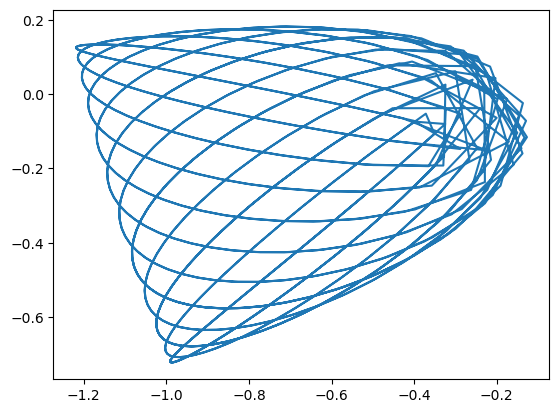

In [43]:
plt.plot(sol.y[0], sol.y[1])

The following code can be used to animation the solution

In [44]:
t = sol.t
x1 = sol.y[0]
y1 = sol.y[1]
x2 = sol.y[2]
y2 = sol.y[3]
x3 = sol.y[4]
y3 = sol.y[5]

Make the animtation:

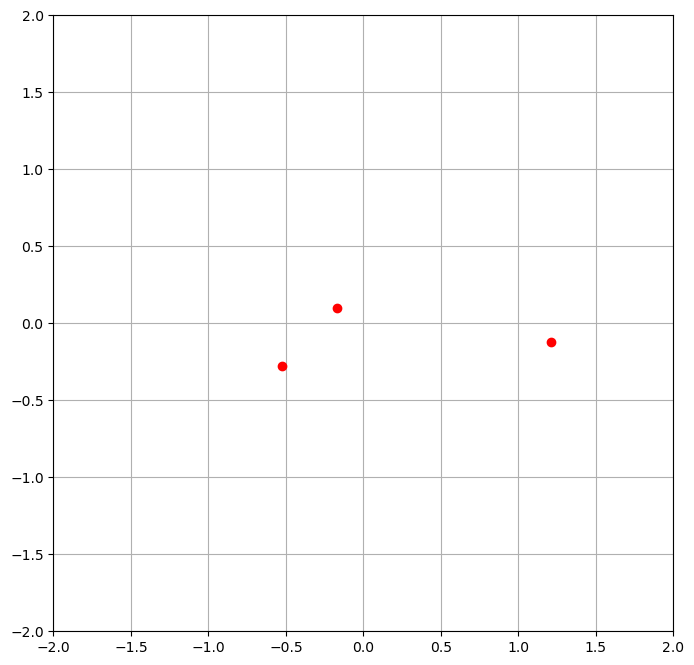

In [45]:
def animate(i):
    ln1.set_data([x1[i], x2[i], x3[i]], [y1[i], y2[i], y3[i]])
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], 'ro', lw=3, markersize=6)
ax.set_ylim(-2, 2)
ax.set_xlim(-2,2)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('plan.gif',writer='pillow',fps=30)

Lesson: Always study your ODE to make sure you use the proper solver!!